In [0]:
import os
import keras
import numpy as np
from PIL import Image
import tensorflow as tf
from random import randint
import matplotlib.pyplot as plt
from keras import backend as k
from keras.utils import np_utils
from keras.optimizers import adam
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import img_to_array
from keras.metrics import categorical_crossentropy
#from sklearn.cross_validation import train_test_split
from keras.layers import Dense,Dropout,Activation,Flatten,Conv2D
from keras.layers.convolutional import Convolution2D,MaxPooling2D

#from keras import backend as K
#K.set_image_dim_ordering('th')


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pprint
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; ')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.compat.v1.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')

TPU address is grpc://10.24.88.34:8470
TPU devices:


In [0]:
#process for reproducing same result
import os
import random as rm

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926
os.environ['PYTHONHASHSEED']='0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(37)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rm.seed(1245)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.compat.v1.random.set_random_seed


# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
from keras import backend as k

sess=tf.compat.v1.Session(target='', graph=None, config=None)
k.set_session(sess)

In [0]:
pp='/content/drive/My Drive/app1/'
train_path=pp+'cat-and-dog/training_set/'
valid_path=pp+'cat-and-dog/valid_set/'
test_path=pp+'cat-and-dog/test_set/'

In [0]:
from keras.preprocessing.image import ImageDataGenerator
img_size=224
datagen = ImageDataGenerator(rescale=1./255)
train_batches=datagen.flow_from_directory(
               train_path,
               target_size=(img_size,img_size),
               classes=['dogs','cats'],
               batch_size=10,
               color_mode="rgb")
valid_batches=datagen.flow_from_directory(
               valid_path,
               target_size=(img_size,img_size),
               classes=['dogs','cats'],
               batch_size=10,
               color_mode="rgb")
test_batches=datagen.flow_from_directory(
               test_path,
               target_size=(img_size,img_size),
               classes=['dogs','cats'],
               batch_size=4,
               color_mode="rgb")

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


# Build VGG16 model-Sequential

VGG16 works with activation="softmax" which does not works here.

In [0]:
#vgg16_model=keras.applications.vgg16.VGG16()
vgg16_model = tf.keras.applications.VGG16(weights='imagenet', input_shape = (224,224,3))

553467904/553467096 [==============================] - 3s 0us/step


In [0]:
vgg16_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

vgg16 is a model not a sequential model. It needs to be transformed to a sequential model.
Sequential model create models layer-by-layer for most problems. It is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs.

In [0]:
type(vgg16_model)


tensorflow.python.keras.engine.training.Model

In [0]:
model=tf.keras.Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
    model.trainable=False  


Remove the last layer of 1000 categories and add the current selection

In [0]:
model.add(tf.keras.layers.Dense(units=2,activation='softmax'))


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit_generator(
                generator=train_batches,
                validation_data=valid_batches,
                steps_per_epoch=4,#train_batches.samples(8005)/train_batches.batch_size(50),
                validation_steps=4,#valid_batches.samples/valid_batches.batch_size, 
                verbose=2,
                shuffle=True,
                epochs=10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
4/4 - 38s - loss: 0.7074 - accuracy: 0.6250 - val_loss: 0.6280 - val_accuracy: 0.7000
Epoch 2/10
4/4 - 38s - loss: 0.6912 - accuracy: 0.7000 - val_loss: 0.6197 - val_accuracy: 0.5750
Epoch 3/10
4/4 - 38s - loss: 0.6186 - accuracy: 0.6250 - val_loss: 0.5168 - val_accuracy: 0.8000
Epoch 4/10
4/4 - 38s - loss: 0.6449 - accuracy: 0.7000 - val_loss: 0.5296 - val_accuracy: 0.7000
Epoch 5/10
4/4 - 38s - loss: 0.6768 - accuracy: 0.6000 - val_loss: 0.5314 - val_accuracy: 0.7000
Epoch 6/10
4/4 - 38s - loss: 0.4826 - accuracy: 0.8250 - val_loss: 0.4878 - val_accuracy: 0.7750
Epoch 7/10
4/4 - 38s - loss: 0.4957 - accuracy: 0.7000 - val_loss: 0.4804 - val_accuracy: 0.8250
Epoch 8/10
4/4 - 38s - loss: 0.4668 - accuracy: 0.7500 - val_loss: 0.4954 - val_accuracy: 0.7500
Epoch 9/10
4/4 - 38s - loss: 0.4882 - accuracy: 0.7250 - val_loss: 0.5090 - val_accuracy: 0.7500
Epoch 10/10
4/4 - 38s - loss: 0.3710 - accuracy: 0.

# Prediction

In [0]:
from keras.preprocessing.image import load_img
# load an image from file
image_path='/content/drive/My Drive/app1/cat-and-dog/dog.6.jpg'
image = load_img(image_path, target_size=(224, 224))

In [0]:
np.shape(image)

(224, 224, 3)

In [0]:
from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)

In [0]:
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)

In [0]:
#from keras.applications.vgg16 import decode_predictions
# predict the probability across all output classes
yhat = model.predict(image)
yhat

array([[9.999974e-01, 2.623602e-06]], dtype=float32)

In [0]:
#from keras.applications.vgg16 import decode_predictions
# convert the probabilities to class labels
#label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
#label = label[0][0]
# print the classification
#print('%s (%.2f%%)' % (label[1], label[2]*100))

# Build VGG16 model-Freez layers

In [0]:
#keras.applications.vgg16.VGG16()
#include_top=False ---> exclude the last layer of the VGG model.
vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))

# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
%tensorflow_version 1.x


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
# Getting output tensor of the last VGG layer that we want to include
x = layer_dict['block5_pool'].output

# Stacking a new simple convolutional network on top of it    
#x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
#x = MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, activation=tf.nn.softmax)(x)

# Creating new model. Please note that this is NOT a Sequential() model.
from keras.models import Model
custom_model = tf.compat.v1.keras.Model(vgg_model.input,outputs=x)

# Make sure that the pre-trained bottom layers are not trainable
for layer in custom_model.layers[:-3]:
    layer.trainable = False

# Do not forget to compile it
custom_model.compile(loss='categorical_crossentropy',
                     optimizer='rmsprop',
                     metrics=['accuracy'])

custom_model.fit_generator(
                generator=train_batches,
                validation_data=valid_batches,
                steps_per_epoch=4,#train_batches.samples(8005)/train_batches.batch_size(50),
                validation_steps=4,#valid_batches.samples/valid_batches.batch_size,
                verbose=2,
                #shuffle=False,
                epochs=10,
                shuffle=True
                )

Epoch 1/10
4/4 - 37s - loss: 13.9692 - accuracy: 0.3750 - val_loss: 8.7847 - val_accuracy: 0.4250
Epoch 2/10
4/4 - 39s - loss: 3.5760 - accuracy: 0.5500 - val_loss: 3.3384 - val_accuracy: 0.6250
Epoch 3/10
4/4 - 37s - loss: 5.4671 - accuracy: 0.4750 - val_loss: 1.4427 - val_accuracy: 0.7250
Epoch 4/10
4/4 - 38s - loss: 1.3234 - accuracy: 0.7000 - val_loss: 2.1414 - val_accuracy: 0.5500
Epoch 5/10
4/4 - 37s - loss: 3.0616 - accuracy: 0.6750 - val_loss: 6.3716 - val_accuracy: 0.5000
Epoch 6/10
4/4 - 37s - loss: 2.1334 - accuracy: 0.7000 - val_loss: 0.7962 - val_accuracy: 0.8000
Epoch 7/10
4/4 - 38s - loss: 3.1319 - accuracy: 0.5000 - val_loss: 1.2214 - val_accuracy: 0.5500
Epoch 8/10
4/4 - 37s - loss: 2.3859 - accuracy: 0.5000 - val_loss: 2.5103 - val_accuracy: 0.4250
Epoch 9/10
4/4 - 37s - loss: 1.6792 - accuracy: 0.6250 - val_loss: 0.8206 - val_accuracy: 0.7250
Epoch 10/10
4/4 - 37s - loss: 1.5944 - accuracy: 0.6500 - val_loss: 0.6445 - val_accuracy: 0.7500


In [0]:
yhat = custom_model.predict(image)
yhat

array([[1., 0.]], dtype=float32)

# Build VGG16 model-Initial weight

In [0]:
#keras.applications.vgg16.VGG16()
vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))

for layer in vgg_model.layers[:5]:
    layer.trainable = True

for layer in vgg_model.layers:
    print(layer, layer.trainable)
    

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb935856860> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb935634208> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb9356344e0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb9356307b8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb935630630> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb935639978> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb9355c2b38> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb9355c29b0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb9355cacf8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb9355d0438> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb9355d4358> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb9355d8

In [0]:
#Adding custom Layers 
x = vgg_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
predictions = tf.keras.layers.Dense(2, activation="softmax")(x)

model_final = tf.compat.v1.keras.Model(vgg_model.input, outputs = predictions)

In [0]:
# creating the final model 

# Do not forget to compile it
model_final.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])


model_final.fit_generator(
                generator=train_batches,
                validation_data=valid_batches,
                steps_per_epoch=4,#train_batches.samples/train_batches.batch_size,,
                validation_steps=4,#valid_batches.samples/valid_batches.batch_size,,
                verbose=2,
                shuffle=True, 
                epochs=10)

Epoch 1/10
4/4 - 79s - loss: 1.4508 - accuracy: 0.5500 - val_loss: 0.7026 - val_accuracy: 0.4750
Epoch 2/10
4/4 - 84s - loss: 3.0722 - accuracy: 0.5000 - val_loss: 0.6731 - val_accuracy: 0.6500
Epoch 3/10
4/4 - 80s - loss: 0.7066 - accuracy: 0.5750 - val_loss: 0.6854 - val_accuracy: 0.5750
Epoch 4/10
4/4 - 77s - loss: 0.6918 - accuracy: 0.5250 - val_loss: 0.7844 - val_accuracy: 0.4250
Epoch 5/10
4/4 - 78s - loss: 0.8490 - accuracy: 0.5000 - val_loss: 0.6984 - val_accuracy: 0.4500
Epoch 6/10
4/4 - 78s - loss: 0.6948 - accuracy: 0.5000 - val_loss: 0.7381 - val_accuracy: 0.4250
Epoch 7/10
4/4 - 78s - loss: 0.7232 - accuracy: 0.5000 - val_loss: 0.6997 - val_accuracy: 0.4750
Epoch 8/10
4/4 - 77s - loss: 0.7033 - accuracy: 0.4500 - val_loss: 0.7327 - val_accuracy: 0.3750
Epoch 9/10
4/4 - 77s - loss: 0.7606 - accuracy: 0.4500 - val_loss: 0.6879 - val_accuracy: 0.5750
Epoch 10/10
4/4 - 78s - loss: 0.7190 - accuracy: 0.5750 - val_loss: 0.6923 - val_accuracy: 0.5250


# Data Augmentation

Data Augmentation occures when creating new data with modification.
Filpp, Rotate, Zoom,Color change,Cropping

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc,ndimage
import keras
from keras import backend as k
from keras.preprocessing.image import ImageDataGenerator

In [0]:
gen=ImageDataGenerator(rotation_range=10,width_shift_range=0.1,
                       height_shift_range=0.1,shear_range=0.15,
                       zoom_range=0.1,channel_shift_range=10,
                       horizontal_flip=True)

In [0]:
import cv2
image_path='/content/drive/My Drive/app1/cat-and-dog/dog.6.jpg'

In [0]:
image=cv2.imread(image_path)

In [0]:
np.shape(image)

(488, 499, 3)

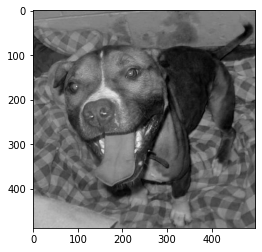

In [0]:
import matplotlib.pyplot as plt
plt.imshow(image[:,:,0], cmap='gray')
plt.show()

generate batches of image

In [0]:
np.shape(image)

(488, 499, 3)

In [0]:
image = np.moveaxis(image, -1, 0)
image.shape

(3, 488, 499)

In [0]:
image_batch = image.reshape((1,) + image.shape)

In [0]:
np.shape(image_batch)

(1, 3, 488, 499)

Get 10 sample of the batches

In [0]:
aug_iter=gen.flow(image_batch, batch_size=2)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 3, 488, 499) (499 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [0]:
aug_images=[next(aug_iter)[0].astype(np.uint8) for i in range(10)]
np.shape(aug_images)

(10, 3, 488, 499)

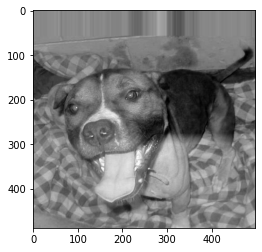

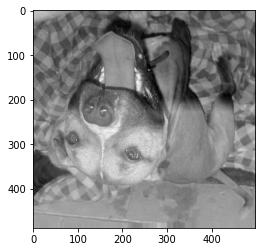

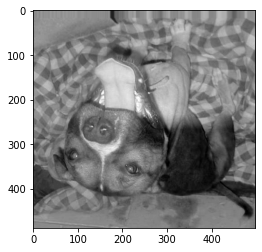

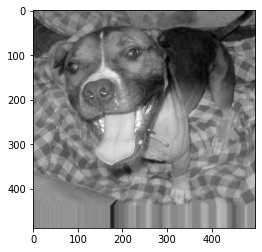

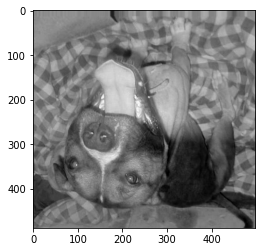

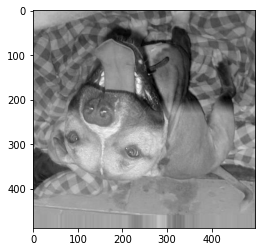

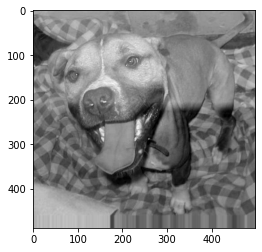

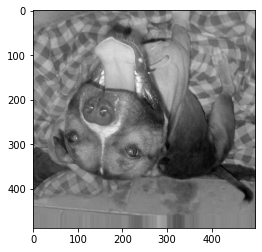

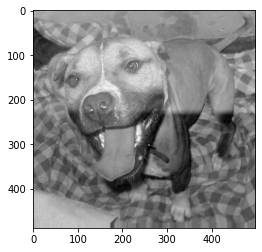

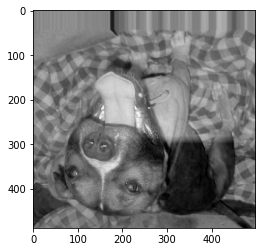

In [0]:
for i in range(0,10):
    img = aug_images[i]
    plt.imshow(img[1,:,:].astype('uint8'), cmap='gray')
    plt.show()    